In [1]:
import numpy as np
import pandas as pd 

import os
import json

from tqdm import tqdm

import cv2
    
# Pytorch
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# GPU need
GPU = True

if GPU and torch.cuda.is_available():
    print('using device: cuda')
    device = torch.device("cuda:0")
else:
    print('using device: cpu')
    device = torch.device("cpu")

# TPU need
TPU = False
if TPU:
    print('using device: tpu')
    !apt-get update && apt-get install -y python3-opencv
    !pip install opencv-python

import matplotlib.pyplot as plt

using device: cpu


# Data Preparation

In [2]:
root_dir = "/kaggle/input/benetech-making-graphs-accessible"

train_folder = os.path.join(root_dir, 'train')
test_folder = os.path.join(root_dir, 'test')

train_annotations_folder = os.path.join(train_folder, 'annotations')
train_images_folder = os.path.join(train_folder, 'images')

test_images_folder = os.path.join(test_folder, 'images')

## Data Loading Method

In [3]:
def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)
    return img_norm

def load_annotation(json_file):
    with open(json_file, 'r') as f:
        annotation = json.load(f)
    return annotation

def load_image(image_file):
    # Load image
    #if GPU == True:

    img = cv2.imread(image_file)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = normalize_image(img)
    return img

## Data Augmentation Method

In [4]:
import random

# Random crop
def random_crop(imgs, imgs_augmented):
    for img in imgs:
        h, w = img.shape[:2]
        crop_w, crop_h = w // 2, h // 2
        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)
        x2 = x1 + crop_w
        y2 = y1 + crop_h
        img = img[y1:y2, x1:x2]
        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

# Random rotation
def random_rotation(imgs, imgs_augmented):
    for img in imgs:
        rows, cols = img.shape[:2]
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        img = cv2.warpAffine(img, M, (cols, rows))
        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

# Random mixed transformation
def random_mixedtran(imgs, imgs_augmented):
    for img in imgs:
        h, w = img.shape[:2]
        crop_w, crop_h = w // 2, h // 2
        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)
        x2 = x1 + crop_w
        y2 = y1 + crop_h
        img = img[y1:y2, x1:x2]

        if np.random.rand() < 0.5:
            img = cv2.flip(img, 1)

        angle = np.random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), angle, 1)
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

## Data Loading

### Path

In [5]:
# Get all the training images and annotations path
train_images_path = sorted([os.path.join(train_images_folder, f) for f in os.listdir(train_images_folder)])
train_annotations_path = sorted([os.path.join(train_annotations_folder, f) for f in os.listdir(train_annotations_folder)])

test_images_path = sorted([os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder)])

print('# of train images:', len(train_images_path))
print('# of train annotations:', len(train_annotations_path))
print('# of test images:', len(test_images_path))

# of train images: 60578
# of train annotations: 60578
# of test images: 5


### Anotation

In [6]:
train_annotations = [load_annotation(f) for f in tqdm(train_annotations_path)]

100%|██████████| 60578/60578 [06:15<00:00, 161.28it/s]


*Chart Type + Path Dataframe*

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode the chart-type
label_encoder = LabelEncoder()

train_charts_type = [a['chart-type'] for a in train_annotations]
train_charts_numtype = label_encoder.fit_transform(train_charts_type)
y = train_charts_numtype

print(np.unique(train_charts_numtype))
print(np.unique(train_charts_type))

#test_charts_type = label_encoder.fit_transform(['line', 'line', 'vertical bar', 'dot', 'vertical bar'])
#test_charts_numtype = label_encoder.fit_transform(test_charts_type)
#y_test = test_charts_numtype

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0 1 2 3 4]
['dot' 'horizontal_bar' 'line' 'scatter' 'vertical_bar']


In [8]:
# Combine train_images_path and y into dataframe
train_df_path = pd.DataFrame({'image': train_images_path, 'chart-type': train_charts_numtype})

# Group the df for different chart-type
train_df_path_grouped = train_df_path.groupby('chart-type')
train_df_path_grouped = [train_df_path_grouped.get_group(x) for x in train_df_path_grouped.groups]

*Type 0 (DOT)*

In [9]:
# Load all the training images for type 0
train_images_path_0 = train_df_path_grouped[0]
train_images_path_0 = train_images_path_0['image'].values

batch_size = 100
train_images_0 = []
for i in tqdm(range(0, len(train_images_path_0)-1, batch_size)):
    train_images_batch_0 = train_images_path_0[i:i + batch_size]
    batch_images_0 = [load_image(f) for f in train_images_batch_0]
    train_images_0.extend(batch_images_0)

# train_images_0_augmented = []
# augmented_num = 2
# for i in tqdm(range(augmented_num)): 
#     random_crop(train_images_0, train_images_0_augmented)

100%|██████████| 52/52 [00:45<00:00,  1.14it/s]


In [10]:
print(len(train_images_0))

5131


*Type 1 (HORIZONTAL BAR)*


In [11]:
# Load all the training images for type 1
train_images_path_1 = train_df_path_grouped[1]
train_images_path_1 = train_images_path_1['image'].values

batch_size = 100
train_images_1 = []
for i in tqdm(range(0, len(train_images_path_1)-1, batch_size)):
    train_images_batch_1 = train_images_path_1[i:i + batch_size]
    batch_images_1 = [load_image(f) for f in train_images_batch_1]
    train_images_1.extend(batch_images_1)

train_images_1_augmented = []
augmentednum = 25
for i in tqdm(range(augmentednum)): 
    random_crop(train_images_1, train_images_1_augmented)
    random_rotation(train_images_1, train_images_1_augmented)
    random_mixedtran(train_images_1, train_images_1_augmented)

100%|██████████| 25/25 [00:01<00:00, 18.76it/s]


In [12]:
print(len(train_images_1_augmented))

5475


In [13]:
# Load all the training images for type 2, 3, 4
reserved_num = 5000

train_images_path_2 = train_df_path_grouped[2]
train_images_path_2 = train_images_path_2['image'].values
train_images_path_2 = np.random.choice(train_images_path_2, reserved_num)

batch_size = 100
train_images_2 = []
for i in tqdm(range(0, len(train_images_path_2)-1, batch_size)):
    train_images_batch_2 = train_images_path_2[i:i + batch_size]
    batch_images_2 = [load_image(f) for f in train_images_batch_2]
    train_images_2.extend(batch_images_2)

        
train_images_path_3 = train_df_path_grouped[3]
train_images_path_3 = train_images_path_3['image'].values
train_images_path_3 = np.random.choice(train_images_path_3, reserved_num)

batch_size = 100
train_images_3 = []
for i in tqdm(range(0, len(train_images_path_3)-1, batch_size)):
    train_images_batch_3 = train_images_path_3[i:i + batch_size]
    batch_images_3 = [load_image(f) for f in train_images_batch_3]
    train_images_3.extend(batch_images_3)

train_images_path_4 = train_df_path_grouped[4]
train_images_path_4 = train_images_path_4['image'].values
train_images_path_4 = np.random.choice(train_images_path_4, reserved_num)

batch_size = 100
train_images_4 = []
for i in tqdm(range(0, len(train_images_path_4)-1, batch_size)):
    train_images_batch_4 = train_images_path[i:i + batch_size]
    batch_images_4 = [load_image(f) for f in train_images_batch_4]
    train_images_4.extend(batch_images_4)

100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


In [14]:
train_images = train_images_0 + train_images_1_augmented + train_images_2 + train_images_3 + train_images_4
y_train = [0]*len(train_images_0) + [1]*len(train_images_1_augmented) + [2] * len(train_images_2) + [3] * len(train_images_3) + [4] * len(train_images_4)

In [15]:
test_num = 1000
random_init = random.randint(0, 50000)
test_images_path = train_images_path[random_init:random_init+test_num]
y_test = train_charts_numtype[random_init:random_init+test_num]
test_images = []
for i in range(0, len(test_images_path)-1, batch_size):
    test_images_batch = test_images_path[i:i + batch_size]
    batch_images_test = [load_image(f) for f in test_images_batch]
    test_images.extend(batch_images_test)
    if i % 1000 == 0:
        print('Have loaded', i+1000, 'Test images')

Have loaded 1000 Test images


In [16]:
# y_t = pd.DataFrame(y_test)
# value_counts = y_t.value_counts()
# print(value_counts)
# y_t = pd.DataFrame(y_train)
# value_counts = y_t.value_counts()
# print(value_counts)

X_train = np.array([np.reshape(train_image, (128*128*1)) for train_image in train_images])
X_test = np.array([np.reshape(test_image, (128*128*1)) for test_image in test_images])
X = np.concatenate((X_train, X_test))
del X_train
del X_test
y = np.concatenate((y_train,y_test))
del y_train
del y_test

In [20]:
def plot_embedding_2d(X, y, title=None):      
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)    
    X = (X-x_min) / (x_max - x_min) 
    fig = plt.figure()    
    ax = fig.add_subplot(1,1,1)
    for i in range(X.shape[0]):
        ax.text(
        X[i,0],X[i,1],            
        str(y[i]),            
        color = plt.cm.Set1(y[i]/10),            
        fontdict = {'weight':'bold', 'size':9}
        )
    if title is not None:
        plt.title(title)
        plt.show()

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X = pca.fit_transform(X)

# # Plot scree plot
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Scree Plot')
# plt.show()

# # Plot cumulative explained variance
# var_exp = np.cumsum(pca.explained_variance_ratio_)
# plt.bar(range(1, var_exp.size + 1), var_exp)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Cumulative explained variance')
# plt.show()

# plot_embedding_2d(X_pca_train, y_train, 'sklearn PCA')

# from sklearn.manifold import Isomap
# isomap = Isomap(n_components=50, n_neighbors=25)

# X_pca_train = isomap.fit_transform(X_pca_train)
# X_pca_test = isomap.fit_transform(X_pca_test)
#plot_embedding_2d(X_pca_train, y_train, 'sklearn Isomap')

In [ ]:
!nvidia-smi
!cat /usr/local/cuda/version.txt
!yes Y | conda install faiss-gpu cudatoolkit=10.0 -c pytorch
!apt search openblas
!yes Y | apt install libopenblas-dev
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2 — wildcards ‘lib/*’
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2 — wildcards ‘site-packages/*’
!cp -r site-packages/* /opt/conda/lib/python3.6/site-packages/
# !export LD_LIBRARY_PATH=”/kaggle/working/lib/” 
!cp /kaggle/working/lib/libfaiss.so /usr/local/cuda/lib64/

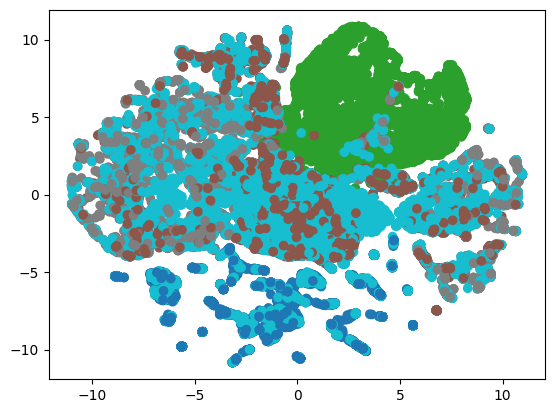

In [19]:
#tsne降维
!pip install numba
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, 
            perplexity=10, 
            learning_rate=200, 
            n_iter=300, 
            method='barnes_hut', 
            n_jobs=-1)
X_tsne = tsne.fit_transform(X)
plot_embedding_2d(X_tsne, y, 'sklearn tsne')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score
tree= DTC()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier as RFC
forest = RFC(n_estimators=1000, random_state=0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print(y_pred)

Accuracy: 0.74
Accuracy: 0.77
[4 0 1 ... 1 2 2]


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1068
           1       0.98      0.99      0.98      1101
           2       0.65      0.68      0.66      1076
           3       0.75      0.85      0.80      1029
           4       0.49      0.40      0.44      1048

    accuracy                           0.77      5322
   macro avg       0.76      0.77      0.76      5322
weighted avg       0.76      0.77      0.76      5322



In [24]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(y_pred)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1068
           1       0.97      0.98      0.98      1101
           2       0.65      0.74      0.69      1076
           3       0.69      0.91      0.78      1029
           4       0.70      0.32      0.44      1048

    accuracy                           0.79      5322
   macro avg       0.79      0.79      0.77      5322
weighted avg       0.79      0.79      0.77      5322

[4 0 1 ... 1 2 2]


In [25]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=5,  
    max_depth=10, 
    learning_rate=0.1,  
    n_estimators=200  
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print(y_pred)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1068
           1       0.98      0.99      0.98      1101
           2       0.66      0.72      0.69      1076
           3       0.71      0.90      0.79      1029
           4       0.61      0.35      0.44      1048

    accuracy                           0.79      5322
   macro avg       0.78      0.79      0.77      5322
weighted avg       0.78      0.79      0.78      5322

[4 0 1 ... 1 2 2]


In [27]:
from sklearn .svm import SVC
from sklearn.preprocessing import StandardScaler as SC
from sklearn.metrics import accuracy_score
import pandas as pd
data1=pd.DataFrame(X_train)
data2=pd.DataFrame(X_test)
model=SVC(kernel='rbf',C=1000)
res=model.fit(data1,y_train)
res.predict(data2)
accuracy_score(res.predict(data2),y_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print(y_pred)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1068
           1       0.98      0.99      0.98      1101
           2       0.66      0.72      0.69      1076
           3       0.71      0.90      0.79      1029
           4       0.61      0.35      0.44      1048

    accuracy                           0.79      5322
   macro avg       0.78      0.79      0.77      5322
weighted avg       0.78      0.79      0.78      5322

[4 0 1 ... 1 2 2]
